In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the tensors

In [54]:
template_data_path = "/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI002S0295/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI002S0295_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt"
template_data = torch.load(template_data_path)
#template_data = template_data[:,::2,::2,::2]

In [55]:
template_data = template_data[:,4:164:2,8:200:2,8:168:2]
template_data.shape

torch.Size([1, 80, 96, 80])

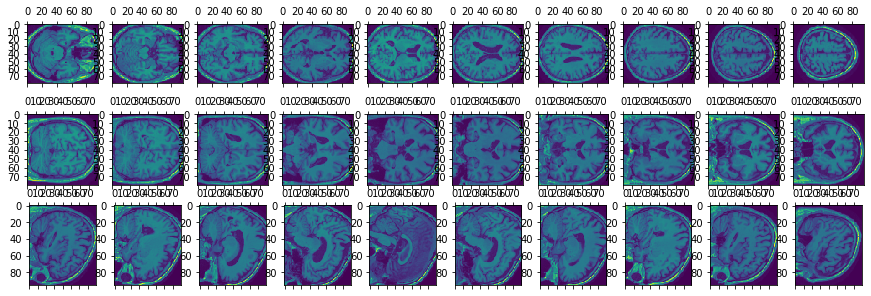

In [6]:
fig, axes = plt.subplots(3,10, figsize=(15,5))

for i in range(10):
    axes[0][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[2][i].matshow(template_data[0][20 + 5*i])

#plt.matshow(template_data[0][:,:,40])
plt.show()

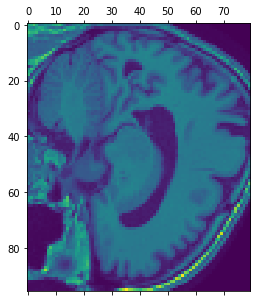

In [7]:
plt.matshow(template_data[0][30])
plt.show()

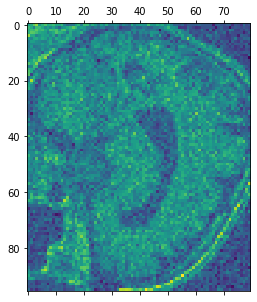

In [8]:
# Illustraion of the noise added to the discriminator

template_data /= template_data.max()
plt.matshow(template_data[0][30] + torch.normal(torch.zeros(template_data[0][30].shape), 0.1))
plt.show()

In [9]:
caps_info = pd.read_csv('/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE']].set_index(['participant_id','session_id'])

caps_info

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (117,118,119,310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


age diagnosis  MMSE
participant_id   session_id                      
sub-ADNI002S0295 ses-M00     84.8        CN  28.0
                 ses-M06     85.3        CN  28.0
                 ses-M12     85.8        CN  30.0
                 ses-M24     87.0        CN  29.0
                 ses-M36     87.8        CN  28.0
...                           ...       ...   ...
sub-ADNI941S6581 ses-M00     74.4        CN  30.0
                 ses-M12     75.4       NaN   NaN
                 ses-M24     76.4       NaN  30.0
sub-ADNI941S6803 ses-M00     75.0       MCI  28.0
sub-ADNI941S6854 ses-M00     86.2        AD  30.0

[16319 rows x 3 columns]

In [11]:
data = torch.load('ADNI_small')

In [12]:
print(f"There are {data['data'].shape[0]} visits with a total of {data['data'].shape[1]*data['data'].shape[2]*data['data'].shape[3]} dimentions")

There are 4724 visits with a total of 614400 dimentions


## Load the models

In [136]:
sys.path.append('/home/benoit.sautydechalon/deformetrica')
from deformetrica.core.model_tools.neural_networks.networks import CVAE_3D, ACVAE_3D, VAE_GAN
from deformetrica.support.utilities.general_settings import Settings

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Settings().dimension = 256 
Settings().device = device

checkpoint = torch.load('../VAE_beta_6', map_location=device)
model = VAE_GAN()
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [137]:
model.to(device)
_, _, reconstructed = model.VAE(torch.FloatTensor(template_data.unsqueeze(0)).to(device))
reconstructed = reconstructed.cpu().detach().numpy()[0]

fig, axes = plt.subplots(3,10, figsize=(15,5))

for i in range(10):
    axes[0][i].matshow(reconstructed[0][:,:,20 + 5*i])
    axes[1][i].matshow(reconstructed[0][:,20 + 5*i])
    axes[2][i].matshow(reconstructed[0][20 + 5*i])

#plt.matshow(template_data[0][:,:,40])
plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 7.80 GiB total capacity; 2.57 GiB already allocated; 19.56 MiB free; 2.70 GiB reserved in total by PyTorch)

## Visual QC for reconstruction

In [ ]:
template_data = data['data'][50].unsqueeze(0)

In [ ]:
model.to(device)
_, _, reconstructed = model.VAE(torch.FloatTensor(template_data.unsqueeze(0)).to(device))
reconstructed = reconstructed.cpu().detach().numpy()[0]

fig, axes = plt.subplots(6,10, figsize=(15,10), gridspec_kw={'height_ratios':[1,.7,.62,1,.7,.62]})
plt.subplots_adjust(wspace=0.02, hspace=0.02)

for i in range(10):
    axes[2][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[0][i].matshow(template_data[0][20 + 5*i])
    axes[5][i].matshow(reconstructed[0][:,:,20 + 5*i])
    axes[4][i].matshow(reconstructed[0][:,20 + 5*i])
    axes[3][i].matshow(reconstructed[0][20 + 5*i])
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

## Data-analysis on the encoded images

In [7]:
encoded = torch.load('../deformetrica/deformetrica/LAE_experiments/encoded_datasetCAE_300_epochs_5e-5_lr')

In [32]:
data = encoded['data']

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [28]:
data = scale(data)

In [27]:
data.mean()

tensor(0.5189)

In [33]:
covar_matrix = PCA(n_components = 20)

In [34]:
covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features


array([68.7, 72.7, 74.1, 75. , 75.6, 76.1, 76.6, 77. , 77.3, 77.6, 77.9,
       78.2, 78.5, 78.8, 79.1, 79.3, 79.5, 79.7, 79.9, 80.1])

## Data-analysis on the true images

In [26]:
data = torch.load('ADNI_small')

In [27]:
data = data['data']

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [33]:
data = (data-data.mean())/data.std()

In [34]:
covar_matrix = PCA(n_components = 20)

In [36]:
n_samples, nx, ny, nz = data.shape
data = data.reshape((n_samples, nx*ny*nz))

covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([13.5, 19.2, 22.9, 24.8, 26.6, 28.2, 29.7, 30.9, 32. , 33.1, 34.1,
       35. , 35.7, 36.4, 37.1, 37.8, 38.4, 39. , 39.5, 40. ])